# Transformation matrix

We need to calculate and store a transformation matrix that can be used for mapping all rgb images to the irccam perspective. See the `camera-mapping.ipynb` notebook for more details on the SIFT/RANSAC approach we use here.

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.abspath(''), '..'))
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from datasets import create_dataset as cd

In [2]:
def plot_img(img):
    figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    implot = plt.imshow(img, cmap='gray')
    

In [40]:
# timestamp = '20180112140300'
# timestamp = '20180112142000'
# timestamp = '20180222121900'
timestamp = '20180112105100'
timestamp = '20180112110700'
# timestamp = '20180112101100'
vis_img = cd.get_vis_img(timestamp)
vis_img = cd.process_vis_img(vis_img)
# plot_img(vis_img)
ir_img = cd.get_irccam_data(str(int(timestamp)))
ir_img = cd.process_irccam_img(ir_img)
# plot_img(ir_img)

In [89]:
def get_matches(timestamp):
    vis_img = cd.get_vis_img(timestamp)
    vis_img = cd.process_vis_img(vis_img)
    ir_img = cd.get_irccam_data(str(int(timestamp)))
    ir_img = cd.process_irccam_img(ir_img)
    vis_gray = cv2.cvtColor(vis_img, cv2.COLOR_RGB2GRAY)
    ir_gray = np.interp(ir_img, (ir_img.min(), ir_img.max()), (0, 255)).astype(np.uint8)
    sift = cv2.SIFT_create()
    vis_kp, vis_des = sift.detectAndCompute(vis_gray, None)
    ir_kp, ir_des = sift.detectAndCompute(ir_gray, None)

    matcher = cv2.BFMatcher()
    kp_matches = matcher.match(vis_des, ir_des)
    match_dist = np.array([m.distance for m in kp_matches])
    close_matches = np.delete(kp_matches, np.where(match_dist > 300))

    pixel_dist = np.array([np.linalg.norm(np.array(vis_kp[m.queryIdx].pt) - np.array(ir_kp[m.trainIdx].pt)) for m in close_matches])
    close_matches = close_matches[np.where(pixel_dist < 140)]

    src_pts = np.float32([ vis_kp[m.queryIdx].pt for m in close_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ ir_kp[m.trainIdx].pt for m in close_matches ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)
    draw_params = dict(matchesMask=mask.ravel().tolist(), flags=2)
    close_match_img = cv2.drawMatches(vis_gray,vis_kp,ir_gray,ir_kp,close_matches,None, **draw_params)
    
    return (src_pts[np.where(mask.ravel())], dst_pts[np.where(mask.ravel())]), close_match_img

(24, 1, 2)
(34, 1, 2)


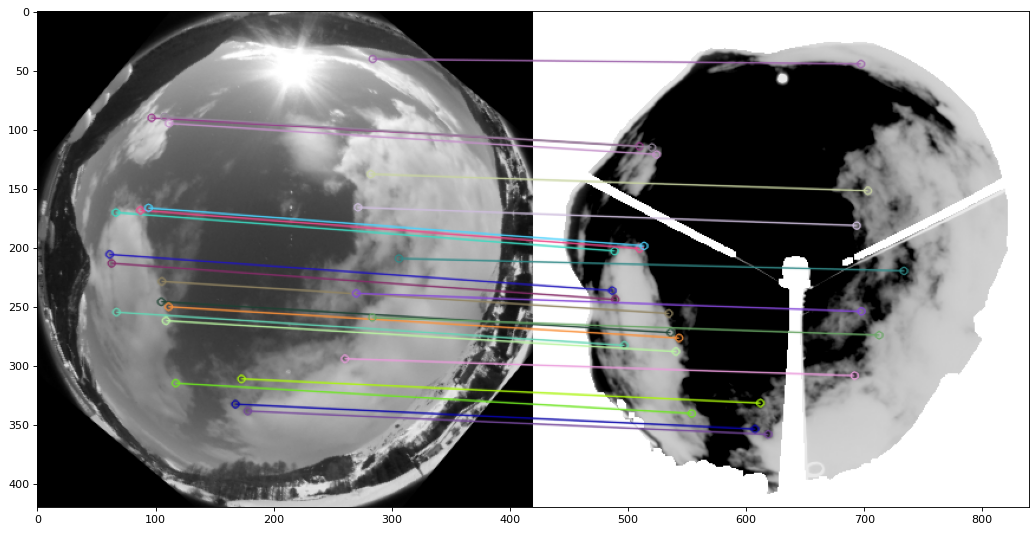

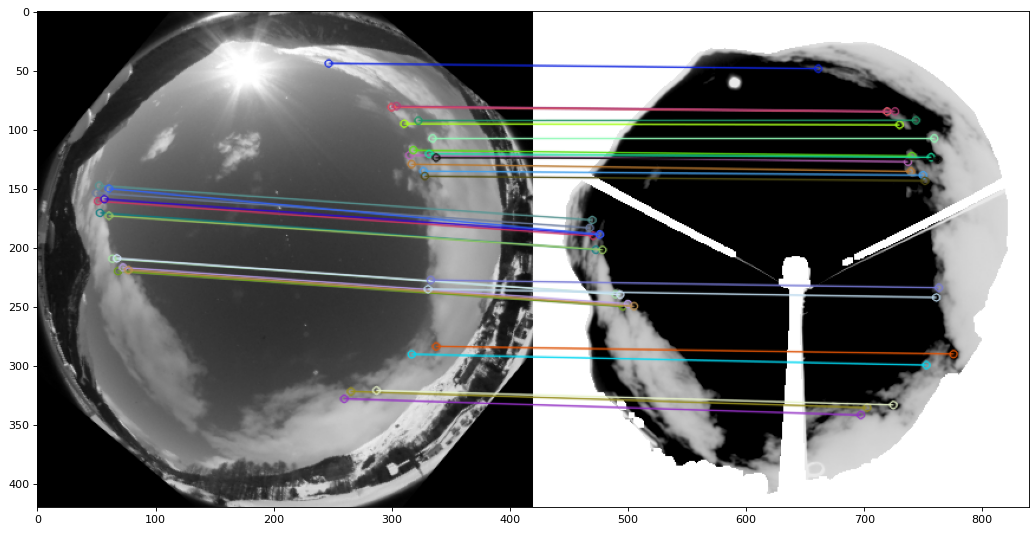

In [102]:
timestamps = ['20180112110700', '20180112101100']
results = [get_matches(ts) for ts in timestamps]
for (matches, img) in results:
    print(matches[0].shape)
    plot_img(img)

In [103]:
all_src_pts = np.concatenate([matches[0] for (matches, _) in results])
all_dst_pts = np.concatenate([matches[1] for (matches, _) in results])

M, mask = cv2.findHomography(all_src_pts, all_dst_pts, cv2.RANSAC, 10.0)
print(all_src_pts.shape[0], sum(mask.ravel()))

58 57


In [98]:
def plot_overlay(img1, img2):
    img1_color = np.zeros((img1.shape[0], img1.shape[1], 3), dtype=np.uint8)
    img1_color[:, :, 2] = img1
    img2_color = np.zeros((img2.shape[0], img2.shape[1], 3), dtype=np.uint8)
    img2_color[:, :, 1] = img2
    overlay = cv2.addWeighted(img1_color, 0.5, img2_color, 0.5, 0)
    plot_img(overlay)

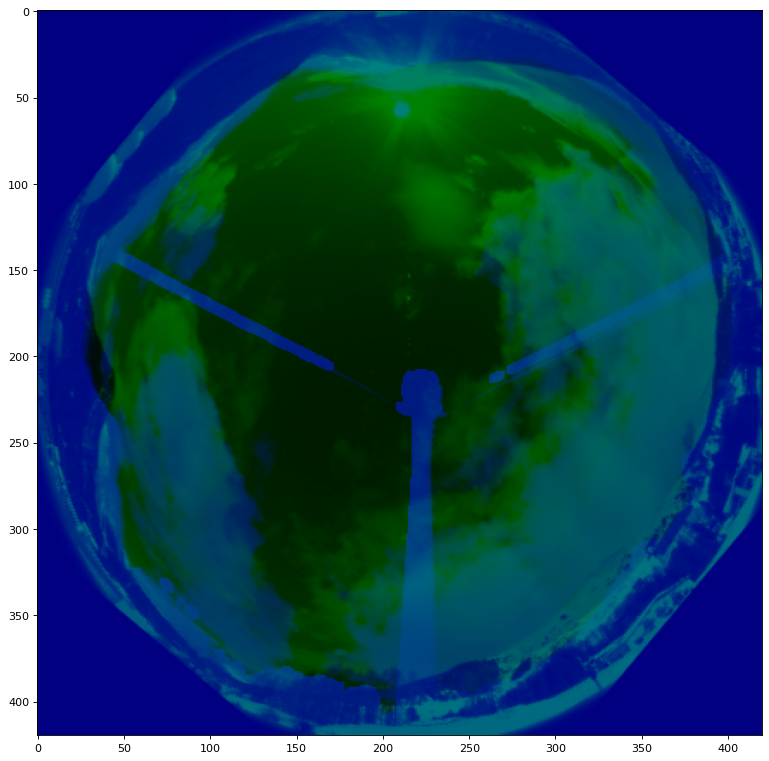

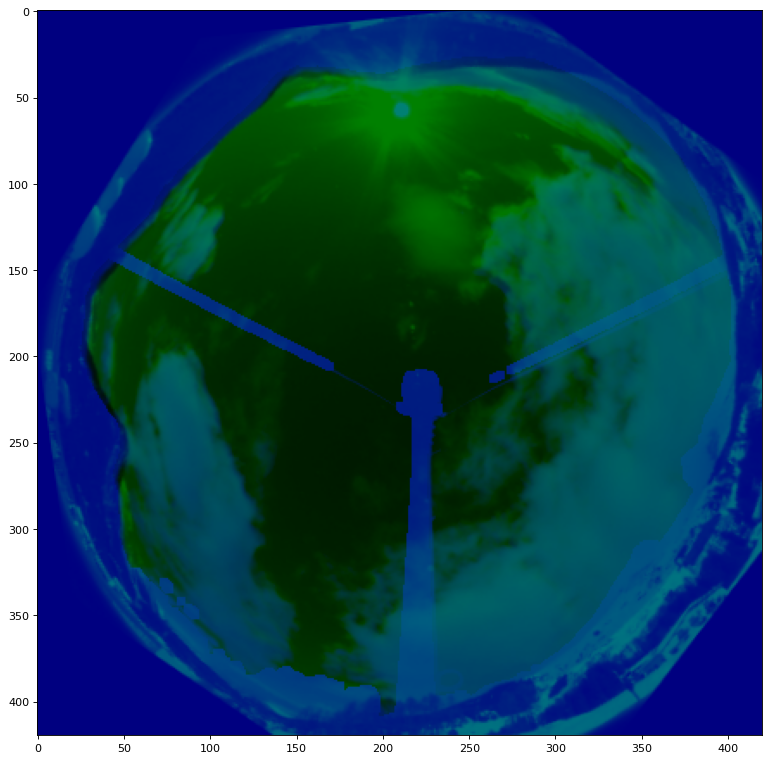

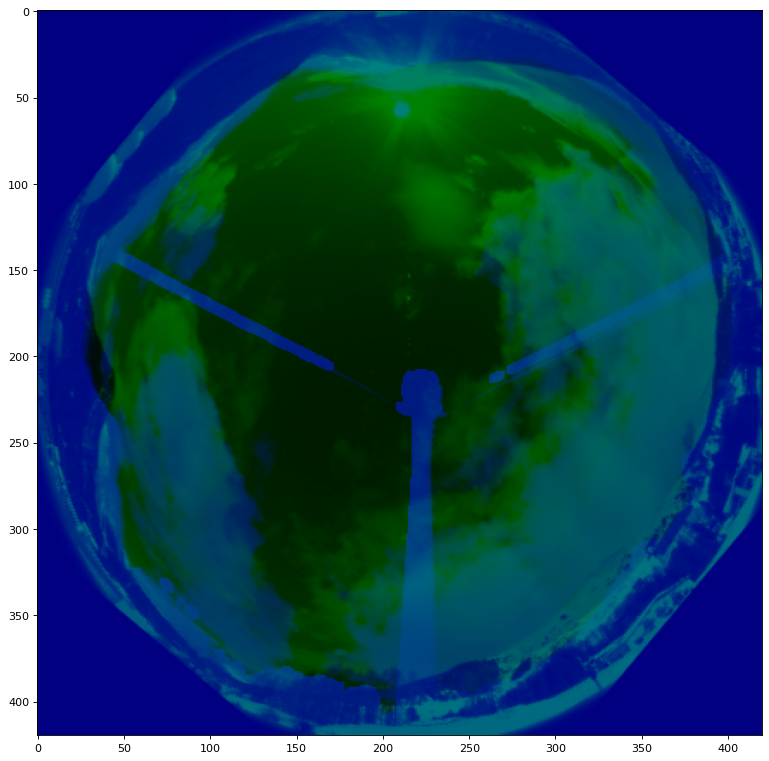

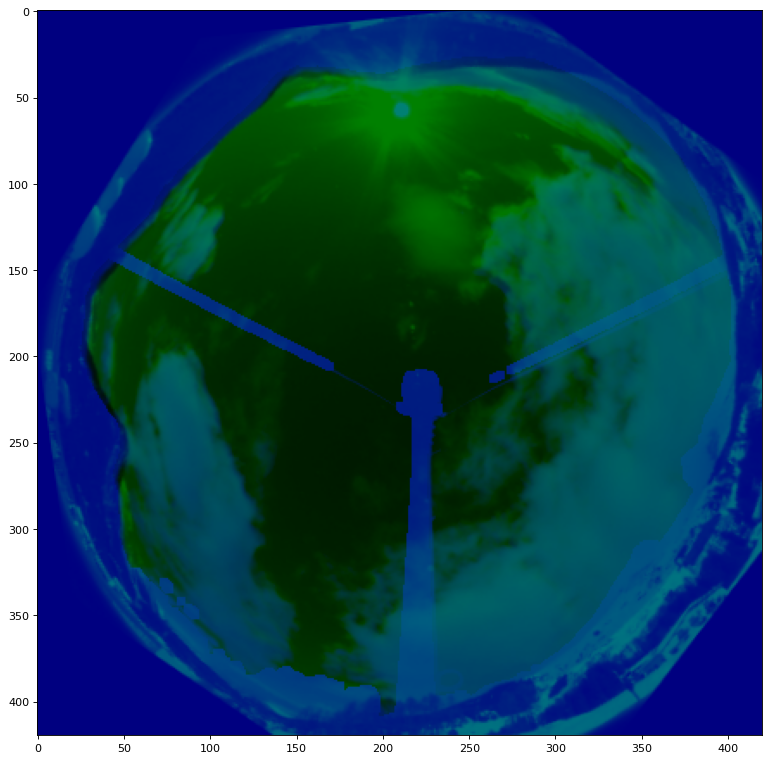

In [107]:
for ts in timestamps:
    vis_img = cd.get_vis_img(timestamp)
    vis_img = cd.process_vis_img(vis_img)
    ir_img = cd.get_irccam_data(str(int(timestamp)))
    ir_img = cd.process_irccam_img(ir_img)
    vis_gray = cv2.cvtColor(vis_img, cv2.COLOR_RGB2GRAY)
    ir_gray = np.interp(ir_img, (ir_img.min(), ir_img.max()), (0, 255)).astype(np.uint8)
    vis_warped = cv2.warpPerspective(vis_gray, M, (vis_gray.shape[0], vis_gray.shape[1]))
    plot_overlay(ir_gray, vis_gray)
    plot_overlay(ir_gray, vis_warped)

In [109]:
np.savetxt('trans_matrix.csv', M, delimiter=',')